# Chapter 6 Temporal-Difference Learning

## Common rl interfaces from the previous chapter

In [1]:
# rough interfaces

class Agent(object) :
    def __init__(self, env, policy) :
        self.env = env
        self.policy = policy
        self.time = 0
    
    def step(self) :
        current_state = self.env.state()
        action = self.policy.get_action(current_state)
        reward = self.env.action(action)
        new_state = self.env.state()
        self.state_changed(self.time, action, current_state, new_state, reward)
        self.time = self.time + 1

    def state_changed(self, time, action, old_state, new_state, reward) :
        pass
    
class Environment(object) :
    def state(self) :
        pass
    
    def is_terminal_state(self) :
        return False
    
    def action(self, act) : # transit states and return reward
        pass

    # def check_dynamics(self, state, act) : # give state, action and get next state and reward
    #    pass

class Policy(object) :
    def get_action(self, state) :
        pass

## Blackjack environment from the previous chapter

In [2]:
# Blackjack environment
# two possible actions for player : hit, stick
# three states : 1. player's current score, 2. if player has at least one ace card, 3. dealer's face-up card value
# dynamics has following probabilities (assumed independent trials) :
#   there are 12 cards and 3 10-value cards.
#   so the probability of 10 value card is 3/12 and that of non-10 value card including ace is 1/12
#   we can simulate this by random generation of range of 1 to 12

import numpy as np

class Blackjack(Environment) :
    MAX_CARD_VALUE = 13
    MAX_TOTAL = 21
    MIN_TOTAL = 12
    DEALER_STICK_MIN_VALUE = 17 # dealer will hit if his score will be lower than this value
    
    def __init__(self) :
        super(Blackjack, self).__init__()

    def start(self) :
        self.initialize_states()

    def initialize_states(self) :
        player_card1, player_card2, dealer_card1, dealer_card2 = (self.get_one_card() for i in range(4))
        self.player_score, self.player_has_ace = self.calculate_cards(player_card1, player_card2)
        while self.should_auto_hit(self.player_score, self.player_has_ace) :
            self.hit_player(self.get_one_card())
            
        self.dealer_score, self.dealer_has_ace = self.calculate_cards(dealer_card1, dealer_card2)
        self.dealer_faceup_card = dealer_card1
        while self.should_auto_hit(self.dealer_score, self.dealer_has_ace) :
            self.hit_dealer(self.get_one_card())

        self.check_natural()
        self.finished = self.natural # game finishes by natural
        
    def is_terminal_state(self) :
        return self.finished

    def state(self) :
        return (self.effective_score(self.player_score, self.player_has_ace), self.player_has_ace, self.dealer_faceup_card)
    
    # if hit is True then hit action otherwise stick action is chosen
    def action(self, hit) : # transit states and return reward
        if self.is_terminal_state() :
            print('already reached the terminal state (it''s natural)')
            return self.calculate_reward()

        if hit :
            escore = self.hit_player(self.get_one_card())
            if self.is_bust(escore) :
                self.finished = True
                return -1
        else : # player chose stick. so the game should finish
            self.finished = True
        
        # now the dealer's turn
        dealer_escore= self.effective_score(self.dealer_score, self.dealer_has_ace)
        if dealer_escore < Blackjack.DEALER_STICK_MIN_VALUE : # dealer will always hit (by the static policy)
            dealer_escore = self.hit_dealer(self.get_one_card())
        
        if self.is_bust(dealer_escore) :
            self.finished = True
            return 1
        
        if self.finished :
            return self.calculate_reward()
        else :
            return 0 # the game will continue and we don't discount reward (i.e, gamma = 1)

    def get_one_card(self) :
        card_idx = np.random.randint(0, Blackjack.MAX_CARD_VALUE)
        return self.card_value(card_idx)
        
    def card_value(self, card_idx) :
        value = card_idx + 1
        if value >= 10 :
            value = 10
        return value
    
    def calculate_cards(self, card1, card2) :
        total = card1 + card2
        has_usable_ace = (card1 == 1 or card2 == 1) and total <= Blackjack.MAX_TOTAL - 10
        return total, has_usable_ace
    
    def effective_score(self, score, has_ace) :
        s = score
        if has_ace and s <= Blackjack.MAX_TOTAL - 10 :
            s = s + 10
        return s

    def should_auto_hit(self, score, has_ace) :
        return self.effective_score(score, has_ace) < Blackjack.MIN_TOTAL
    
    def hit_player(self, card) :
        self.player_score = self.player_score + card
        self.player_has_ace = (self.player_has_ace or card == 1) and self.player_score <= Blackjack.MAX_TOTAL - 10 
        return self.effective_score(self.player_score, self.player_has_ace)

    def hit_dealer(self, card) :
        self.dealer_score = self.dealer_score + card
        self.dealer_has_ace = (self.dealer_has_ace or card == 1) and self.dealer_score <= Blackjack.MAX_TOTAL - 10 
        return self.effective_score(self.dealer_score, self.dealer_has_ace)
    
    def calculate_reward(self) :
        score_diff = self.effective_score(self.player_score, self.player_has_ace) - self.effective_score(self.dealer_score, self.dealer_has_ace)
        return np.sign(score_diff)
    
    def check_natural(self) :
        self.natural = self.is_natural(self.effective_score(self.player_score, self.player_has_ace))
        return self.natural

    def is_natural(self, effective_score) :
        return effective_score == Blackjack.MAX_TOTAL
    
    def is_bust(self, effective_score) :
        return effective_score > Blackjack.MAX_TOTAL

    def check_terminal_state(self, state) :
        player_score, player_has_ace, dealer_faceup_card = state
        effective_score = self.effective_score(player_score, player_has_ace)
        return self.is_natural(effective_score) or self.is_bust(effective_score)


In [3]:
class DictBlackjackPolicy(Policy) :
    MAX_TOTAL = 21

    def __init__(self, policy_dict = None) :
        if policy_dict is None :
            self.policy_dict = {}
        else :
            self.policy_dict = policy_dict

    def state_key(self, state) :
        player_score, player_has_ace, dealer_faceup_card = state
        return str(player_score) + '-' + ('1' if player_has_ace else '0') + '-' + str(dealer_faceup_card)
        
    def get_action(self, state) : # state is tuple and action is boolean (if hit True or False)
        key = self.state_key(state)
        action = self.policy_dict.get(key)
        if action is None :
            action = np.random.randint(0, 2) == 1 # just use random policy if previous is not given
        return action
    
    def effective_score(self, score, has_ace) :
        s = score
        if has_ace and s <= BlackjackPolicy.MAX_TOTAL - 10 :
            s = s + 10
        return s
    
    def update_policy(self, state, action) :
        key = self.state_key(state)
        self.policy_dict[key] = action
        
    def print_policy(self) :
        print(self.policy_dict)

# 6.1 TD Prediction
## Tabular TD(0) for estimating v𝜋
Another name of TD(0) is one-step TD

In [4]:
class TabularTD0Agent(Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, step_size = 0.1, max_value = 1.0, gamma = 1.0, num_episode = NUM_EPISODES) :
        super(TabularTD0Agent, self).__init__(env, policy)
        
        self.step_size = step_size
        self.max_value = max_value
        self.num_episode = num_episode
        self.gamma = gamma
        self._initialize()
    
    def _initialize(self) :
        self.value_dic = {}

    def get_exploring_action(self) :
        a = np.random.randint(0, 2)
        return a == 1

    def get_value(self, state) :
        state_key = self.policy.state_key(state)
        if self.value_dic.get(state_key) is not None :
            return self.value_dic[state_key] # use bootstrapped values
        
        if self.env.check_terminal_state(state) :
            return 0.0
        
        v = np.random.random_sample() * self.max_value
        self.value_dic[state_key] = v
        return v

    def set_value(self, state, value) :
        state_key = self.policy.state_key(state)
        self.value_dic[state_key] = value
    
    def eval_policy(self) :
        for episode in range(self.num_episode) :
            self.env.start()
            while self.env.is_terminal_state() : # case natural. we can't learn policy from natural so ignore this case
                self.env.start()

            state = self.env.state()
            steps = 0
            while not self.env.is_terminal_state() :
                action = self.policy.get_action(state)
                reward = self.env.action(action)
                new_state = self.env.state()
                svalue = self.get_value(state)
                next_svalue = self.get_value(new_state)
                svalue = svalue + self.step_size * (reward + self.gamma * next_svalue - svalue)
                self.set_value(state, svalue)
                state = new_state
                steps = steps + 1
                
            self.end_of_episode(episode, steps)

    def end_of_episode(self, episode, steps) :
        pass
    
    def run(self) :
        self.eval_policy()


In [5]:
env = Blackjack()

policy = DictBlackjackPolicy()
agent_td0 = TabularTD0Agent(env, policy, num_episode = 1000000)
agent_td0.run()

In [6]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d # for '3d' projection

def draw_wireframe(title, xlabel, ylabel, zlabel, xvals, yvals, zvals, rstride=1, cstride=1, draw_surface=False) :
    fig = plt.figure(figsize=(10, 6))
    
    ax3d = fig.add_subplot(111, projection='3d')
    if draw_surface :
        ax3d.plot_surface(xvals, yvals, zvals, rstride=rstride, cstride=cstride, cmap='viridis', edgecolor='none')
    else :
        ax3d.plot_wireframe(xvals, yvals, zvals, rstride=rstride, cstride=cstride)

    ax3d.set_xlabel(xlabel)
    ax3d.set_ylabel(ylabel)
    ax3d.set_zlabel(zlabel)
    ax3d.set_title(title)

    ax3d.set_xlim(np.min(xvals) - 1, np.max(xvals) + 1)
    ax3d.set_ylim(np.min(yvals) - 1, np.max(yvals) + 1)

    plt.show()  

In [7]:
# show the trained state-values in chart
# ace_chart, no_ace_chart x: dealer card, y: player total, action (Hit==True) : red, (Stick==False) : blue

def draw_blackjack_state_value(title, value_dict) :
    ace_x, ace_y, ace_v = np.array(np.arange(1, 11)), np.array([i for i in range(Blackjack.MIN_TOTAL, Blackjack.MAX_TOTAL + 1)]), np.zeros((10, 10), dtype=np.float32) # index, dealer face-up card, player total, state-value
    noace_x, noace_y, noace_v = np.array(np.arange(1, 11)), np.array([i for i in range(Blackjack.MIN_TOTAL, Blackjack.MAX_TOTAL + 1)]), np.zeros((10, 10), dtype=np.float32) # index, dealer face-up card, player total, state-value

    for key, value in value_dict.items() :
        player_score, player_has_ace, dealer_faceup_card = key.split('-')

        if player_has_ace == '1' :
            ace_v[int(dealer_faceup_card) - 1, int(player_score) - Blackjack.MIN_TOTAL] = float(value)
        else :
            noace_v[int(dealer_faceup_card) - 1, int(player_score) - Blackjack.MIN_TOTAL] = float(value)

    # see https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
    X,Y = np.meshgrid(ace_x, ace_y)
    Z = (lambda x, y : ace_v[x - 1, y - Blackjack.MIN_TOTAL])(X, Y)
    draw_wireframe(title + ' (Usable Ace)', 'Dealer Card', 'Player Sum', 'V*', X, Y, Z, rstride=1, cstride=1, draw_surface=True)

    X,Y = np.meshgrid(noace_x, noace_y)
    Z = (lambda x, y : noace_v[x - 1, y - Blackjack.MIN_TOTAL])(X, Y)
    draw_wireframe(title + ' (No usable Ace)', 'Dealer Card', 'Player Sum', 'V*', X, Y, Z, rstride=1, cstride=1, draw_surface=True)


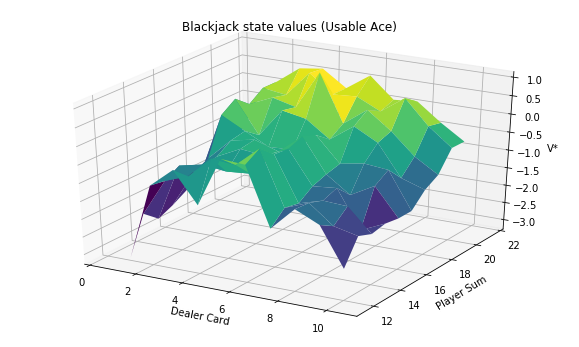

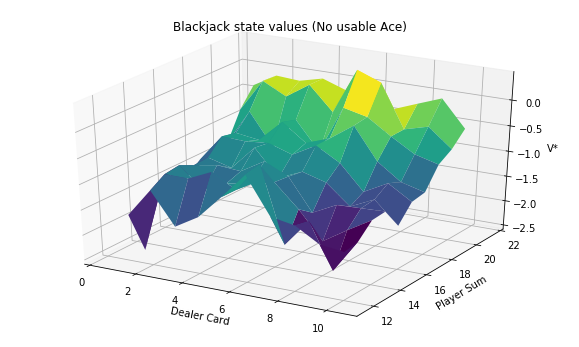

In [8]:
draw_blackjack_state_value('Blackjack state values', agent_td0.value_dic)

## Example 6.2 Random Walk

In [17]:
# Random Walk environment
# two possible actions for player : left, right
# six states : terminal (0), A (1), B (2), C (3), D (4), E (5), terminal (6)
# dynamics has following probabilities (assumed independent trials) :
#   there are 12 cards and 3 10-value cards.
#   so the probability of 10 value card is 3/12 and that of non-10 value card including ace is 1/12
#   we can simulate this by random generation of range of 1 to 12

from enum import Enum
import numpy as np

class Move(Enum) :
    LEFT = -1
    RIGHT = 1

class RandomWalk(Environment) :
    MAX_VALUE = 6
    MIN_VALUE = 0
    
    def __init__(self, initial_position=None) :
        super(RandomWalk, self).__init__()
        self.initial_position = initial_position
        self.start()

    def start(self) :
        if self.initial_position is None :
            self.position = np.random.randint(RandomWalk.MIN_VALUE + 1, RandomWalk.MAX_VALUE)
        else :
            self.position = self.initial_position
        
    def is_terminal_state(self) :
        return self.check_terminal_state(self.position)

    def state(self) :
        return self.position
    
    # if move is True then move_to_left action otherwise move_to_right action is chosen
    def action(self, move) : # transit states and return reward
        if self.is_terminal_state() :
            print('already reached the terminal state') # should not happen
            return 0

        self.position = self.position + move.value
        if self.position == RandomWalk.MAX_VALUE :
            return 1

        return 0

    def check_terminal_state(self, state) :
        return state == RandomWalk.MIN_VALUE or state == RandomWalk.MAX_VALUE


In [18]:
class RandomWalkPolicy(Policy) :
    def __init__(self) :
        super(RandomWalkPolicy, self).__init__()

    def state_key(self, state) :
        return state
        
    def get_action(self, state) : # just random
        return Move.LEFT if np.random.randint(0, 2) == 1 else Move.RIGHT

In [37]:
class RandomWalkTabularTD0Agent(TabularTD0Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, step_size = 0.1, initial_value = 1.0, gamma = 1.0, num_episode = NUM_EPISODES) :
        super(RandomWalkTabularTD0Agent, self).__init__(env, policy, step_size=step_size,
                                                        gamma=gamma, num_episode=num_episode)        
        self.initial_value = initial_value

    def get_value(self, state) :
        if self.initial_value == None :
            return super(RandomWalkTabularTD0Agent, self).get_value(state)
        
        state_key = self.policy.state_key(state)
        if self.value_dic.get(state_key) is not None :
            return self.value_dic[state_key] # use bootstrapped values
        
        if self.env.check_terminal_state(state) :
            return 0.0
        
        self.value_dic[state_key] = self.initial_value
        return self.initial_value

    def end_of_episode(self, episode, steps) :
        # print('end of episode (', episode, ') took ', steps, ' steps')
        episode_checks = [ 1, 10, 100 ]
        if episode + 1 in episode_checks :
            v = np.array([ self.get_value(i) for i in range(1, 6) ])
            if episode + 1 == 1 :
                self.v_1 = v
            elif episode + 1 == 10 :
                self.v_10 = v
            elif episode + 1 == 100 :
                self.v_100 = v
    

In [38]:
env_rw = RandomWalk(initial_position=3) # 3 is C position
policy_rw = RandomWalkPolicy()

v_true = np.array([ i / 6.0 for i in range(1, 6) ])

agent_td0_rw = RandomWalkTabularTD0Agent(env_rw, policy_rw, initial_value = 0.5, step_size = 0.1, num_episode=100)

v_0 = np.array([ agent_td0_rw.get_value(i) for i in range(1, 6) ])

agent_td0_rw.run()

v_1 = agent_td0_rw.v_1
v_10 = agent_td0_rw.v_10
v_100 = agent_td0_rw.v_100


In [45]:
# draw random walk state and estimated values

def draw_random_walk_estimates() :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    xlabels = [ 'A', 'B', 'C', 'D', 'E' ]
    ax.set_xticks([x for x in range(5)])
    ax.set_xticklabels(xlabels)

    x_axis = np.array(range(5))
    ax.plot(x_axis, v_true, color='black', lw=0.8, label='True values')
    ax.text(4, v_true[4], 'True values', color='black')

    ax.plot(x_axis, v_0, color='grey', lw=0.8, label='0')
    ax.text(0, v_0[0], '0', color='grey')

    ax.plot(x_axis, v_1, color='red', lw=0.8, label='1')
    ax.text(3, v_1[3], '1', color='red')

    ax.plot(x_axis, v_10, color='green', lw=0.8, label='10')
    ax.text(4, v_10[4], '10', color='green')

    ax.plot(x_axis, v_100, color='blue', lw=0.8, label='100')
    ax.text(3, v_100[3], '100', color='blue')

    ax.set_xlabel('State')
    ax.set_ylabel('Estimated value')

    plt.show()



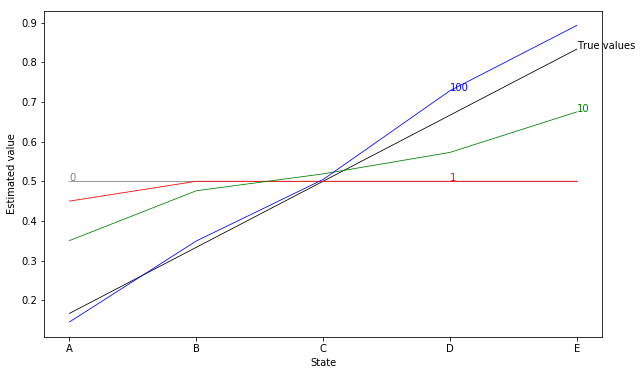

In [46]:
draw_random_walk_estimates()

In [47]:
class RMSTabularTD0Agent(RandomWalkTabularTD0Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, step_size = 0.1, initial_value = 1.0,
                 true_values = None, gamma = 1.0, num_episode = NUM_EPISODES) :
        super(RMSTabularTD0Agent, self).__init__(env, policy, step_size=step_size,
                                                 initial_value=initial_value, gamma=gamma, num_episode=num_episode)
        self.true_values = np.array(true_values)

    def _initialize(self) :
        super(RMSTabularTD0Agent, self)._initialize()
        self.rms = np.zeros(self.num_episode)

    def end_of_episode(self, episode, steps) :
        v = np.array([ self.get_value(i) for i in range(1, 6) ])
        self.rms[episode] = np.sqrt(np.mean(np.square(self.true_values - v)))


In [48]:
env_rw = RandomWalk(initial_position=3) # 3 is C position
policy_rw = RandomWalkPolicy()

v_true = np.array([ i / 6.0 for i in range(1, 6) ])

agent_td0_rms = RMSTabularTD0Agent(env_rw, policy_rw, true_values = v_true, initial_value = 0.5, step_size = 0.05, num_episode=100)
agent_td0_rms.run()
td0_rms_005 = agent_td0_rms.rms

agent_td0_rms = RMSTabularTD0Agent(env_rw, policy_rw, true_values = v_true, initial_value = 0.5, step_size = 0.1, num_episode=100)
agent_td0_rms.run()
td0_rms_01 = agent_td0_rms.rms

agent_td0_rms = RMSTabularTD0Agent(env_rw, policy_rw, true_values = v_true, initial_value = 0.5, step_size = 0.15, num_episode=100)
agent_td0_rms.run()
td0_rms_015 = agent_td0_rms.rms


Every visit Monte Carlo prediction for nonstationary environment. see Eq (6.1)

In [53]:
# non-stationary MC prediction
        
class NonstationaryMCPredictionAgent(Agent) :
    NUM_EPISODES = 5000
    
    def __init__(self, env, policy, true_values = None, 
                 initial_value = 1.0, first_visit = False, step_size=0.1, num_episode = NUM_EPISODES) :
        super(NonstationaryMCPredictionAgent, self).__init__(env, policy)
        
        self.true_values = np.array(true_values)
        self.initial_value = initial_value
        self.first_visit = first_visit
        self.step_size = step_size
        self.num_episode = num_episode
        self._initialize()
    
    def _initialize(self) :
        self.value_dic = {}
        self.rms = np.zeros(self.num_episode)
        
    def get_value(self, state) :
        state_key = self.policy.state_key(state)
        if self.value_dic.get(state_key) is not None :
            return self.value_dic[state_key] # use bootstrapped values
        
        if self.env.check_terminal_state(state) :
            return 0.0
        
        self.value_dic[state_key] = self.initial_value
        return self.initial_value
        
    def generate_episode(self) :
        states, actions, rewards = [], [], []
        self.env.start()
        while self.env.is_terminal_state() : # case natural. we can't learn policy from natural so ignore this case
            self.env.start()
        while True :
            state = self.env.state()
            action = self.policy.get_action(state)
            reward = self.env.action(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            if self.env.is_terminal_state() : # break if it's terminal state
                break
        return states, actions, rewards
        
    def eval_policy(self) :
        #while True :
        for episode in range(self.num_episode) :
            states, actions, rewards = self.generate_episode()
            time_steps = len(states)
            state_is_first = []
            state_key_set = set()
            for state in states :
                state_key = self.policy.state_key(state)
                if state_key not in state_key_set : 
                    state_key_set.add(state_key)
                    state_is_first.append(True)
                else :
                    state_is_first.append(False)
            
            g = 0.0
            gamma = 1.0
            for step in reversed(range(time_steps)) :
                g = gamma * g + rewards[step]
                key = self.policy.state_key(states[step])
                
                if not self.first_visit or state_is_first[step] : # check if it's first visit
                    if self.value_dic.get(key) is None :
                        v = self.initial_value
                    else :
                        v = self.value_dic[key]
                    # update value for non-stationary
                    self.value_dic[key] = v + self.step_size * (g - v)
        
            self.end_of_episode(episode, time_steps)
        # print(self.value_dic)

    def end_of_episode(self, episode, steps) :
        v = np.array([ self.get_value(i) for i in range(1, 6) ])
        self.rms[episode] = np.sqrt(np.mean(np.square(self.true_values - v)))

    def run(self) :
        self.eval_policy()

In [54]:
agent_mc_rms = NonstationaryMCPredictionAgent(env_rw, policy_rw, true_values = v_true, initial_value = 0.5,
                                               first_visit=False, step_size = 0.01, num_episode=100)
agent_mc_rms.run()
mc_rms_001 = agent_mc_rms.rms

agent_mc_rms = NonstationaryMCPredictionAgent(env_rw, policy_rw, true_values = v_true, initial_value = 0.5,
                                               first_visit=False, step_size = 0.02, num_episode=100)
agent_mc_rms.run()
mc_rms_002 = agent_mc_rms.rms

agent_mc_rms = NonstationaryMCPredictionAgent(env_rw, policy_rw, true_values = v_true, initial_value = 0.5,
                                               first_visit=False, step_size = 0.03, num_episode=100)
agent_mc_rms.run()
mc_rms_003 = agent_mc_rms.rms


agent_mc_rms = NonstationaryMCPredictionAgent(env_rw, policy_rw, true_values = v_true, initial_value = 0.5,
                                               first_visit=False, step_size = 0.04, num_episode=100)
agent_mc_rms.run()
mc_rms_004 = agent_mc_rms.rms


In [61]:
# draw random walk policy rms per episodes

def draw_random_walk_rms(draw_td = True, draw_mc = True) :
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    x_axis = np.array(range(100))
    
    if draw_td :
        ax.plot(x_axis, td0_rms_005, color='blue', lw=0.5, label='alpha=0.05')
        ax.text(80, td0_rms_005[80], 'alpha=0.05', color='blue')

        ax.plot(x_axis, td0_rms_01, color='blue', lw=0.8, label='alpha=0.1')
        ax.text(40, td0_rms_01[40], 'alpha=0.1', color='blue')

        ax.plot(x_axis, td0_rms_015, color='blue', lw=1.0, label='alpha=0.15')
        ax.text(10, td0_rms_015[10], 'alpha=0.15', color='blue')
    
        ax.text(10, 0.02, 'TD', color='blue')
    
    if draw_mc :
        ax.plot(x_axis, mc_rms_001, color='red', lw=0.5, label='alpha=0.01', linestyle='-')
        ax.text(20, mc_rms_001[20], 'alpha=0.01', color='red')

        ax.plot(x_axis, mc_rms_002, color='red', lw=0.8, label='alpha=0.02', linestyle='--')
        ax.text(40, mc_rms_002[40], 'alpha=0.02', color='red')

        ax.plot(x_axis, mc_rms_003, color='red', lw=1.0, label='alpha=0.03', linestyle=':')
        ax.text(60, mc_rms_003[60], 'alpha=0.03', color='red')

        ax.plot(x_axis, mc_rms_004, color='red', lw=1.2, label='alpha=0.04', linestyle='-')
        ax.text(80, mc_rms_004[80], 'alpha=0.04', color='red')

        ax.text(50, 0.2, 'MC', color='red')
    
    ax.set_xlabel('Walks/Episodes')
    ax.set_ylabel('Empirical RMS error,\naveraged over states')

    plt.show()

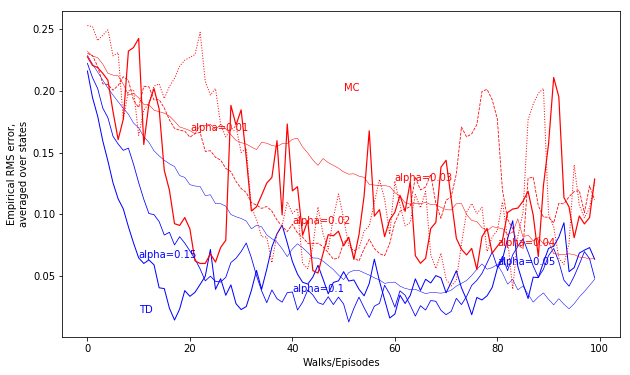

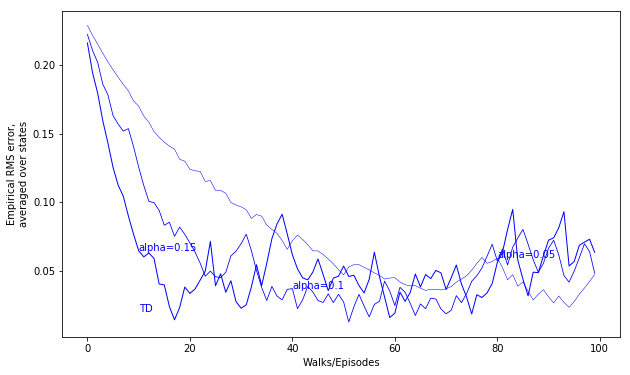

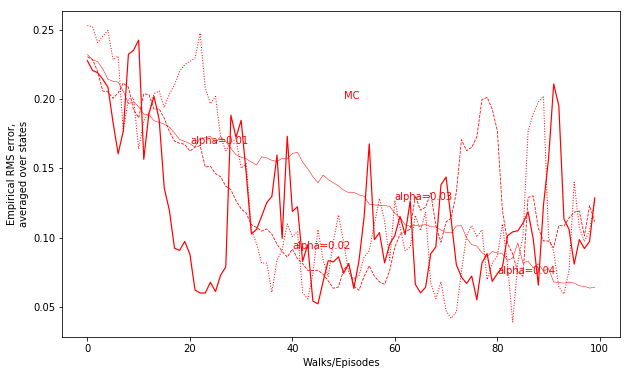

In [62]:
draw_random_walk_rms()
draw_random_walk_rms(draw_mc=False)
draw_random_walk_rms(draw_td=False)

so weird values.. what's wrong with the codes? :-(

## Sarsa (on-policy TD control) for estimating Q

## Q-learning (off-policy TD control) for estimating 𝜋

## Double Q-learning, for estimating Q1 ≈ Q2